In [19]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes,EfficientSU2
from sklearn.utils import shuffle

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer

from qiskit.circuit import ParameterVector

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.opflow import I, Z, X
from qiskit.primitives import Estimator

import torch
from torch.autograd import Variable
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from qiskit_machine_learning.connectors import TorchConnector
from torch.optim import Adam,SGD

In [202]:
j_coupling = -1 #coupling constant J
h_coupling = -3 #coupling constant h
num_qubits=7
Estimator(options={"shots":500})

In [203]:
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
ansatz = RealAmplitudes(num_qubits=num_qubits,reps=5)
qc.h(qr)
qc.compose(ansatz, inplace=True)  

observable = SparsePauliOp.from_list([("X"+"I"*(num_qubits-1) , h_coupling )])

for i in np.arange(1,num_qubits,1):
    observable=observable + SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(num_qubits-1-i) , h_coupling )])
    
for i in range(num_qubits-1):
    observable=observable + (SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(num_qubits-2-i) , j_coupling)]))

    
qnn=EstimatorQNN(
    estimator=Estimator(options={"shots":1000}),
    circuit=qc,
    weight_params=ansatz.parameters,
    observables=observable
    )

In [204]:
def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x)
    plt.show()
def computeMag(x):
    x2=x**2
    return x2.sum()

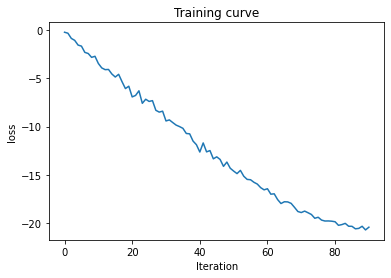

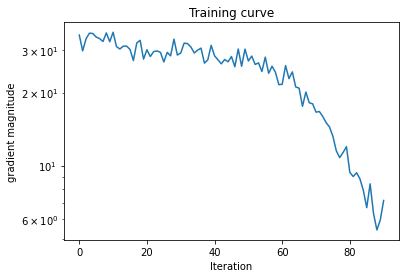

90


In [205]:
init_weights=np.random.rand(qnn.num_weights)*2*np.pi
weights=init_weights

nSteps=50
learning_rate=1e-2
loss=[]
gradMag=[]
for i in range(nSteps):
    
        

    vev=qnn.forward([], weights)[0][0]
    input_grad, weight_grad=qnn.backward([],weights)
    grad=weight_grad[0,0,:]
    weights=weights-learning_rate*grad

    loss.append(vev)
    gradMag.append(computeMag(grad))
    
    if i%10==0:
        
        clear_output(wait=True)
        plt.figure(1)

        callback_graph(loss)
        plt.figure(2)
        plt.yscale('log')
        callback_graph(gradMag,"gradient magnitude")
        print(i)


In [206]:
def SGD(init_weights,learning_rate,nSteps=100):
    loss=[]
    weights=init_weights
    for i in range(nSteps):



        vev=qnn.forward([], weights)[0][0]
        input_grad, weight_grad=qnn.backward([],weights)
        grad=weight_grad[0,0,:]
        weights=weights-learning_rate*grad

        loss.append(vev)

    return loss



In [207]:
learning_rate_list=[1e-3,1e-2,1e-1,1e0,1e1,1e2]


In [208]:
init_weights=np.random.rand(qnn.num_weights)*2*np.pi
weights=init_weights

nSteps=100
learning_rate=1e-2
test_iter=5

In [209]:
loss=SGD(init_weights,learning_rate,nSteps=test_iter)

In [210]:
finalCost_list=[]
for learning_rate in learning_rate_list:
    loss=SGD(init_weights,learning_rate,nSteps=test_iter)
    finalCost_list.append(loss[-1])
    print("finishing ",learning_rate, " final cost =",loss[-1])
finalCost_list=np.array(finalCost_list)
ind=np.where(finalCost_list==finalCost_list.min())[0][0]
best_rate=learning_rate_list[ind]
print("best rate =",best_rate)

finishing  0.001  final cost = -1.6860596663032235
finishing  0.01  final cost = -2.429547911700724
finishing  0.1  final cost = -13.368495592229639
finishing  1.0  final cost = 1.4387414791957271
finishing  10.0  final cost = 3.9885447836495516
finishing  100.0  final cost = -0.1053434070943258
best rate = 0.1


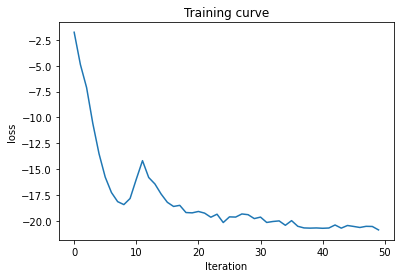

In [211]:
loss=SGD(init_weights,learning_rate=best_rate,nSteps=50)
plt.figure(1)
callback_graph(loss)


In [213]:
def getMag(x):
    x2=x**2
    return np.sqrt(x2.sum())

def getCos(x,y):
    cos=(x*y).sum()/(getMag(x)*getMag(y))
    return cos

def getDot(sampler,weights,rate):
    input_grad,weight_grad=sampler.backward(sampler_input,weights)
    grad0=weight_grad[0,0,:]
    
    newWeights=weights-rate*grad0
    input_grad,weight_grad=sampler.backward(sampler_input,newWeights)
    grad1=weight_grad[0,0,:]
    
    
    return getCos(grad0,grad1),grad0,newWeights
    

In [214]:
def getRate_DIAG(sampler,input_weights,steps=15,ini_rate=1e-1):
    dot_list=[]
    r_list=[]
    w_list=[]
    grad_list=[]
    weights=input_weights
    output_weights=input_weights
    output_rate=ini_rate
    rate=ini_rate
    for i in range(steps):
        dot,grad,weights=getDot(sampler,weights,rate)
        rate=rate*2

        if dot < -0.3:
            print("dot stop")
            output_rate=rate
            #output_weights=weights
            output_weights=(w_list[-1]+weights)/2
            break
            
        if i>1 and dot_list[-1]-dot>0.3:
            print("dot diff stop, dot= ",dot_list[-1],dot)
            if dot>0:
                output_weights=weights
                output_rate=rate
            elif dot<=0:
                output_rate=rate
                output_weights=(w_list[-1]+weights)/2
        
            break
            
            
        
        dot_list.append(dot)
        r_list.append(rate)
        w_list.append(weights)
        grad_list.append(grad)
            
    if output_weights.all()==weights.all():
        dot_list=np.array(dot_list)
        diff=(dot_list[0:-1]-dot_list[1:])
        index=np.where(diff==diff.max())[0][0]
        output_weights=w_list[index]
        output_rate=r_list[index]
        
    
    return output_rate,len(dot_list)


In [215]:
best_rate,iterations=getRate_DIAG(qnn,init_weights,steps=20,ini_rate=1e-3)

dot diff stop, dot=  0.80204185415644 -0.05580339207194593


In [216]:
print("best rate = {}, numer of iteration taken: {}".format(best_rate,iterations))

best rate = 0.128, numer of iteration taken: 8


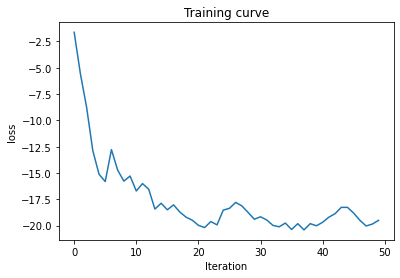

In [217]:
loss=SGD(init_weights,learning_rate=best_rate,nSteps=50)
plt.figure(1)
callback_graph(loss)


In [163]:
def iteration(sampler,input_weights,steps=15,ini_rate=1e-1):
    dot_list=[]
    r_list=[]
    w_list=[]
    grad_list=[]
    weights=input_weights
    output_weights=input_weights
    output_rate=ini_rate
    rate=ini_rate
    for i in range(steps):
        dot,grad,weights=getDot(sampler,weights,rate)
        rate=rate*2

        if dot < -0.3:
            print("dot stop")
            output_rate=rate
            #output_weights=weights
            output_weights=(w_list[-1]+weights)/2
            break
            
        if i>1 and dot_list[-1]-dot>0.3:
            print("dot diff stop, dot= ",dot_list[-1],dot)
            if dot>0:
                output_weights=weights
                output_rate=rate
            elif dot<=0:
                output_rate=rate
                output_weights=(w_list[-1]+weights)/2
        
            break
            
            
        
        dot_list.append(dot)
        r_list.append(rate)
        w_list.append(weights)
        grad_list.append(grad)
            
    if output_weights.all()==weights.all():
        dot_list=np.array(dot_list)
        diff=(dot_list[0:-1]-dot_list[1:])
        index=np.where(diff==diff.max())[0][0]
        output_weights=w_list[index]
        output_rate=r_list[index]
        
    
    return output_weights,output_rate
        

In [167]:
n_train=100
weights=init_weights
ini_rate=1e-2
cost_list_DIAG=[]
rate_list=[]
for i in range(n_train):
    clear_output(wait=True)
    weights,rate=iteration(qnn,weights,steps=20,ini_rate=ini_rate)
    ini_rate=rate/10
    cost=qnn.forward(sampler_input,weights)[0][0]
    cost_list_DIAG.append(cost)
    rate_list.append(rate)

    plt.figure(1)

    plt.xlabel('Iteration')
    plt.plot(range(len(cost_list_DIAG)),cost_list_DIAG)
    #plt.yscale('log')
    plt.show()
    
    plt.figure(2)
    plt.xlabel('Iteration')
    plt.plot(range(len(rate_list)),rate_list)
    plt.yscale('log')
    plt.show()
    
    print(i, cost,rate)
    